# CS4379G Assignment 1 — Netflix Titles Analysis

## Research Questions

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [2]:
df = pd.read_csv("../data/netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Quick Data Check

In [3]:
df.shape, df.columns
df.info()
df.isna().sum().sort_values(ascending=False).head(10)

<class 'pandas.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   show_id       8807 non-null   str  
 1   type          8807 non-null   str  
 2   title         8807 non-null   str  
 3   director      6173 non-null   str  
 4   cast          7982 non-null   str  
 5   country       7976 non-null   str  
 6   date_added    8797 non-null   str  
 7   release_year  8807 non-null   int64
 8   rating        8803 non-null   str  
 9   duration      8804 non-null   str  
 10  listed_in     8807 non-null   str  
 11  description   8807 non-null   str  
dtypes: int64(1), str(11)
memory usage: 825.8 KB


director        2634
country          831
cast             825
date_added        10
rating             4
duration           3
show_id            0
type               0
title              0
release_year       0
dtype: int64

## Cleaning

In [4]:
# Basic cleaning
df = df.copy()

# Standardize column names (optional)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Parse date_added to datetime
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")

# Create year_added for trends
df["year_added"] = df["date_added"].dt.year


## Helper Function(s)

In [5]:
# Helper: explode a comma-separated column into one item per row
def explode_list_column(dataframe, colname):
    s = dataframe[colname].fillna("").astype(str)
    exploded = (
        s.str.split(",")
         .explode()
         .str.strip()
    )
    out = dataframe.loc[exploded.index].copy()
    out[colname] = exploded
    out = out[out[colname] != ""]
    return out

## Analysis 1

In [6]:
titles_per_year = (
    df.dropna(subset=["year_added"])
      .groupby("year_added")
      .size()
      .sort_index()
)

titles_per_year.tail(10)

year_added
2012.0       3
2013.0      10
2014.0      23
2015.0      73
2016.0     418
2017.0    1164
2018.0    1625
2019.0    1999
2020.0    1878
2021.0    1498
dtype: int64

## Visualization 1 + Interpretation

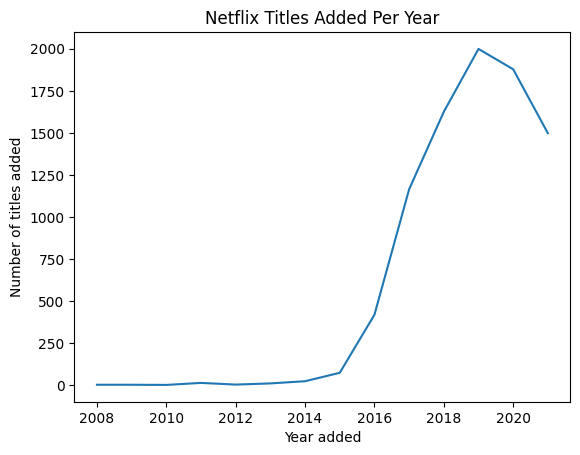

In [7]:
plt.figure()
plt.plot(titles_per_year.index, titles_per_year.values)
plt.title("Netflix Titles Added Per Year")
plt.xlabel("Year added")
plt.ylabel("Number of titles added")
plt.show()

# Interpretation (markdown under the plot):

2–4 sentences comparing how ratings differ between Movies and TV Shows, plus note that we limited to top ratings.

## Analysis 2

In [8]:
ratings_by_type = (
    df.dropna(subset=["type", "rating"])
      .groupby(["type", "rating"])
      .size()
      .reset_index(name="count")
)

# Get top 10 ratings overall so the plot is readable
top_ratings = (
    df["rating"].value_counts().head(10).index
)

ratings_top = ratings_by_type[ratings_by_type["rating"].isin(top_ratings)]

pivot = ratings_top.pivot(index="rating", columns="type", values="count").fillna(0)

pivot


type,Movie,TV Show
rating,,
NR,75.0,5.0
PG,287.0,0.0
PG-13,490.0,0.0
R,797.0,2.0
TV-14,1427.0,733.0
TV-G,126.0,94.0
TV-MA,2062.0,1145.0
TV-PG,540.0,323.0
TV-Y,131.0,176.0


## Visualization 2 + Interpretation

<Figure size 640x480 with 0 Axes>

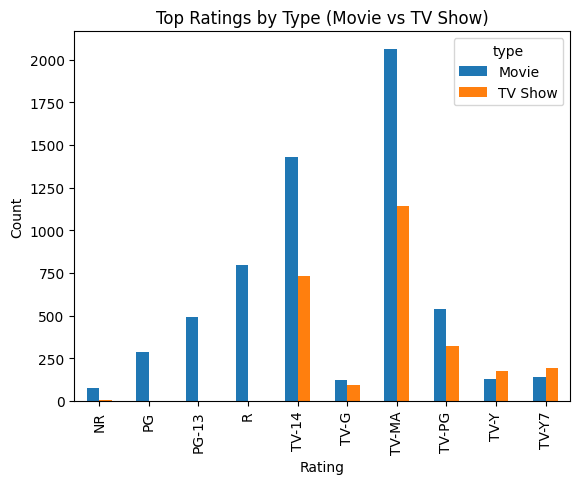

In [9]:
plt.figure()
pivot.plot(kind="bar")
plt.title("Top Ratings by Type (Movie vs TV Show)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Interpretation (markdown under the plot):

2–4 sentences comparing how ratings differ between Movies and TV Shows, plus note that we limited to top ratings.

## Conclusion

In [11]:
import sys
print(sys.executable)


/Users/bellahavel/Desktop/Data_Vis/cs4379g-assignment1/.venv/bin/python
